### 1. Download Dataset

In [1]:
import os
import spacy

In [2]:
# os.system("python -m spacy download en_core_web_sm")
# os.system("python -m spacy download de_core_news_sm")

In [3]:
spacy_german = spacy.load('de_core_news_sm')
spacy_english = spacy.load('en_core_web_sm')

In [4]:
from torchtext.data import Field
from torchtext.datasets import Multi30k

In [5]:
def tokenize_de(text):
    return [tok.text for tok in spacy_german.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_english.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, init_token = '<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize = tokenize_en, init_token = '<sos>', eos_token='<eos>', lower=True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(
    exts=('.de', '.en'), fields=(SRC, TRG)
)

In [7]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

### 2. Network Structures
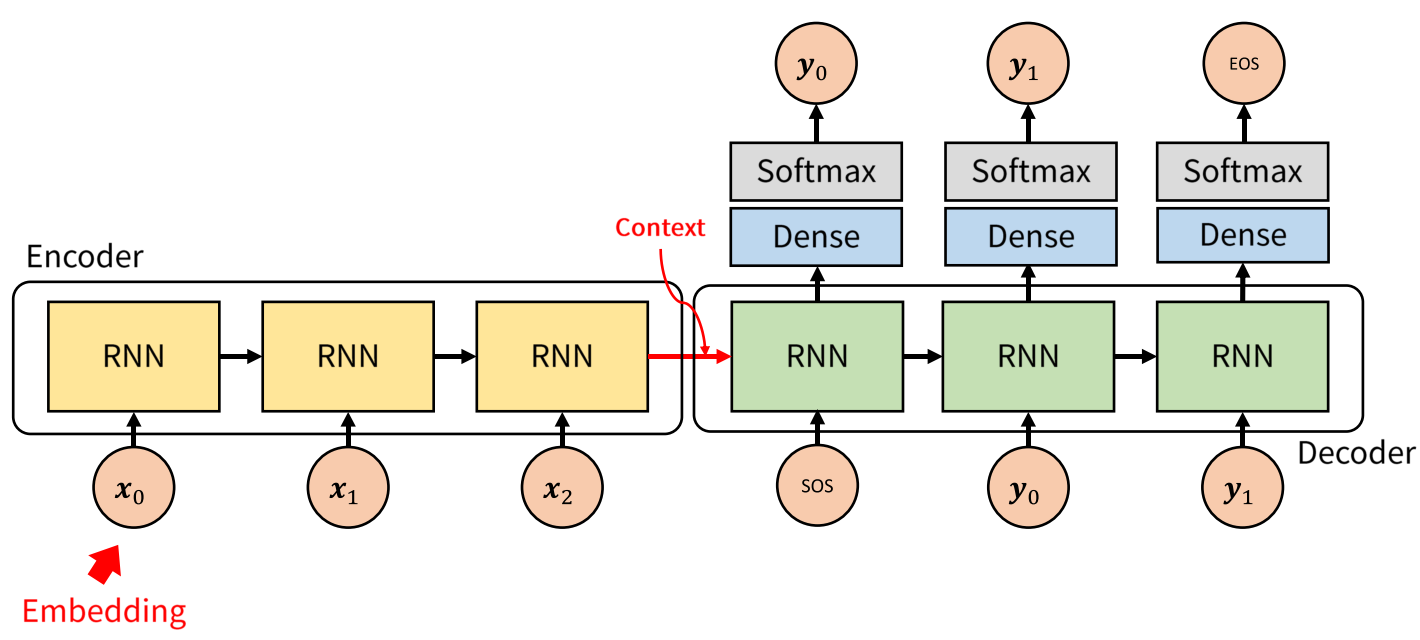

- encoder
    - source -> nn.Embedding -> LSTM -> hidden(context vector) -> return
    - embedding : [vocab_size, dim_embed]
    - LSTM : [dim_embed, hidden_size]
    
- decoder
    - context vector -> LSTM -> fclayer
    - foward : input_data.unsqueeze(0)
        - unsqueeze(확장할 차원)
        - LSTM -> [seq_len, batch, dim_embed] (1, batch, dim_embed)

In [8]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

class seq_Encoder(nn.Module):
    def __init__(self, vocab_size, dim_embed, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(vocab_size, dim_embed)
        self.lstm = nn.LSTM(dim_embed, hidden_size, num_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        outputs, (hidden, cell) = self.lstm(self.dropout(self.embed(src)))
        return hidden, cell       

In [20]:
class seq_Decoder(nn.Module):
    def __init__(self, output_size, dim_embed, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(output_size, dim_embed)
        self.lstm = nn.LSTM(dim_embed, hidden_size, num_layers, dropout=dropout)
        self.fclayer = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_data, hidden, cell):
        
        input_data = input_data.unsqueeze(0)
        embedded = self.dropout(self.embed(input_data))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fclayer(output.squeeze(0))
        
        return prediction, hidden, cell        

In [21]:
import random

class seq2seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, source, target, tf_ratio=0.5):
        # target : [seq_len, batch, emb_dim]
        batch_size = target.shape[1]
        translation_length = target.shape[0]
        target_vocab_size = self.decoder.output_size
        
        # output을 저장하기 위한 장소
        outputs = torch.zeros(translation_length, batch_size, target_vocab_size).to(self.device)
        hidden, cell = self.encoder(source)
        input_trans = target[0,:]
        
        for t in range(1, translation_length):
            output, hidden, cell = self.decoder(input_trans, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < tf_ratio
            input_trans = target[t] if teacher_force else output.argmax(1)
        return outputs

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = seq_Encoder(len(SRC.vocab), 64,64,1,0.3)
dec = seq_Decoder(len(TRG.vocab), 64,64,1,0.3)
seq_net = seq2seq(enc, dec, device).to(device)
optimizer = torch.optim.Adam(seq_net.parameters(), lr=0.01)

In [23]:
from torchtext.data import BucketIterator
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = 256,
    device = device
)

### 3. Train the translator network

In [24]:
pad_index = TRG.vocab.stoi[TRG.pad_token]
lossfcn = nn.CrossEntropyLoss(ignore_index = pad_index)

for epoch in range(10):
    loss_epoch = 0
    for batch in train_iterator:
        source_data = batch.src
        target_data = batch.trg
        target_pred = seq_net(source_data, target_data)
        target_pred = target_pred[1:].view(-1, target_pred.shape[-1])
        target_data = target_data[1:].view(-1)
        optimizer.zero_grad()
        loss = lossfcn(target_pred, target_data)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    print("Epoch",epoch,"Loss", loss_epoch/len(train_iterator))

Epoch 0 Loss 5.208516246394107
Epoch 1 Loss 4.558371966345268
Epoch 2 Loss 4.36157162565934
Epoch 3 Loss 4.253211805694981
Epoch 4 Loss 4.193361980873242
Epoch 5 Loss 4.1222353065223025
Epoch 6 Loss 4.060023454197666
Epoch 7 Loss 4.037495751129954
Epoch 8 Loss 4.017295801848696
Epoch 9 Loss 3.960566995436685
